#            Outlier/Anomaly detection. 

  * Our goal is to use four different models to classify a severely imbalanced credit card data set. The class imbalance is 98.3% good credit customers and 1.7% defaulting customers.  We will not rebalance the data but rather leave the data as is it because we are assuming this imbalance reflects the reality of the population.

  * We will adopt an anomaly detection method to try classify the imbalanced classes.  We will treat the defaulting customers as outliers or anomalies in our data.

 


##### There are two methods to identifying outliers in data.   

  1. Anomaly detection method: This is an unsupervised method where you train the model on data which contains some outliers. You do not pass any labels to the model. You test the trained model on new data which also contains outliers. Outliers typically will represent a small proportion of both train and test data.  


  2. Novelty detection method: This is a semi-supervised method. You train model on data with only inliers and no outliers in the data set. Next you test it on new data and see if it predicts if the new data belongs to the inlier group or not. Models will predict if new data is an inlier and belonging to the group it was trained on or if it is an outlier.   


 
    
#### Contamination factor:  For each model we use we will also define a key hyperparameter which is the contamination factor. For the purpose of  the classification task below  we will set the contamination factor to equal the size of the minority class which is 1.7%.  
  
    


## Define the algorithms. 

 ### The algorithms used in this notebook are as follows:
1. Robust covariance: assumes gaussian distribution. When data is not unimodal this model should underperform the others, You should pass data that is centred(subtract mean ). Below I have not centred the data. Outlier detection from covariance estimation may break or not perform well in high-dimensional settings. In particular, one will always take care to work with n_samples > n_features ** 2. (1)


2. One class SVM: was originally designed to be trained on one class and then tested on new data to see if the new data belongs to the class or belongs to another class. This is how novelty detection models are typically trained. The decision boundary is influenced by hyperparameter "nu" which is akin to the contamination hyperparameter used in the other models used in this notebook. The model is is known to be sensitive to outliers. We will use an RBF Kernel.(2)


3. Isolation Forest: Tree based algorithm. Assumes anomalies have a different feature space and have a shorter tree depth versus inliers. Random partitioning by each tree produces noticeably shorter paths for anomalies.When a forest of random trees collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies(2).Multimodal data is ok. Non parametric and not beholden to any distribution assumptions in the data such as Robust covariance. If data is high in dimensionality this model is not a silver bullet but may perform relatively better than other models used in this notebook. (3) 


4. Local Outlier Factor: The Local Outlier Factor (LOF) algorithm is a density based model and an unsupervised anomaly detection method which computes the local density deviation of a given data point with respect to its neighbors. It considers as outliers the samples that have a substantially lower density than their neighbors. If data is moderately high in dimensionality this model is viewed as an efficient means of identifying outliers/anomalies.(4)


 
All models are available in sklearn.(5)

#### References: 
(1) Robust Covariance:(research paper),  Rousseeuw, P.J., Van Driessen, K. “A fast algorithm for the minimum covariance determinant estimator” Technometrics 41(3), 212 (1999)

(2) One Class SVM (research paper),  Schölkopf, Bernhard, et al. "Estimating the support of a high-dimensional distribution." Neural computation 13.7 (2001): 1443-1471.

(3) Isolation Forest (research paper), Liu, Fei Tony, Ting, Kai Ming and Zhou, Zhi-Hua. “Isolation forest.” Data Mining, 2008. ICDM’08. Eighth IEEE International Conference on.


(4) Local Outlier Factor (research paper),  https://www.dbs.ifi.lmu.de/Publikationen/Papers/LOF.pdf
 
 
(5) SKLEARN outlier detection models: https://scikit-learn.org/stable/modules/outlier_detection.html#outlier-detection



## Import required libraries

In [1]:
import numpy as np
import random
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score
from sklearn import svm
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

### Custom function for notebook to assess each model

In [2]:
# custom function for notebook to assess each model
def get_anomaly_detection_stats(model,X_train,X_test,y_test):
    """ Pass to the function your model, X_train and X_test. 
    Y_test needs to be passed to the function 
    to enable model evaluation.  
    Function produces a confusion matrix and the following metrics:
    F1, recall, precision and roc_auc scores. All are weighted to allow for class imbalance"""
    
    #Get predictions. Each model produces 1 or -1 for its predictions. 1 is inlier ad -1 is outlier.
    #predictions are transformed to 0 for inlier and 1 for outlier.
    model_pred= model.fit(X_train).predict(X_test)
    model_pred=pd.Series(model_pred).map(lambda x: 1 if x == -1 else 0)
     
    #Print f1 score, reall, precision,roc_auc    
    #Print metrics for each label, and find their average weighted by support, i.e size of class.      
    print(f" F1 score : {f1_score(y_test, model_pred, average='weighted')}")
    print(f" Recall score : {recall_score(y_test, model_pred, average='weighted')}")
    print(f" Precision score : {precision_score(y_test, model_pred, average='weighted')}")
    print(f" roc_auc : {roc_auc_score(y_test, model_pred, average='weighted')}")
           
    #Plot confusion matrix on test data
    cf_matrix = confusion_matrix(y_test, model_pred)     
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='ocean')

### Read in csv

In [3]:
# Credit card csv contains X and Y . Algorithms are only trained on X.
cards= pd.read_csv('./credit_cards.csv',index_col=0)

### EDA :  Visualize the data.

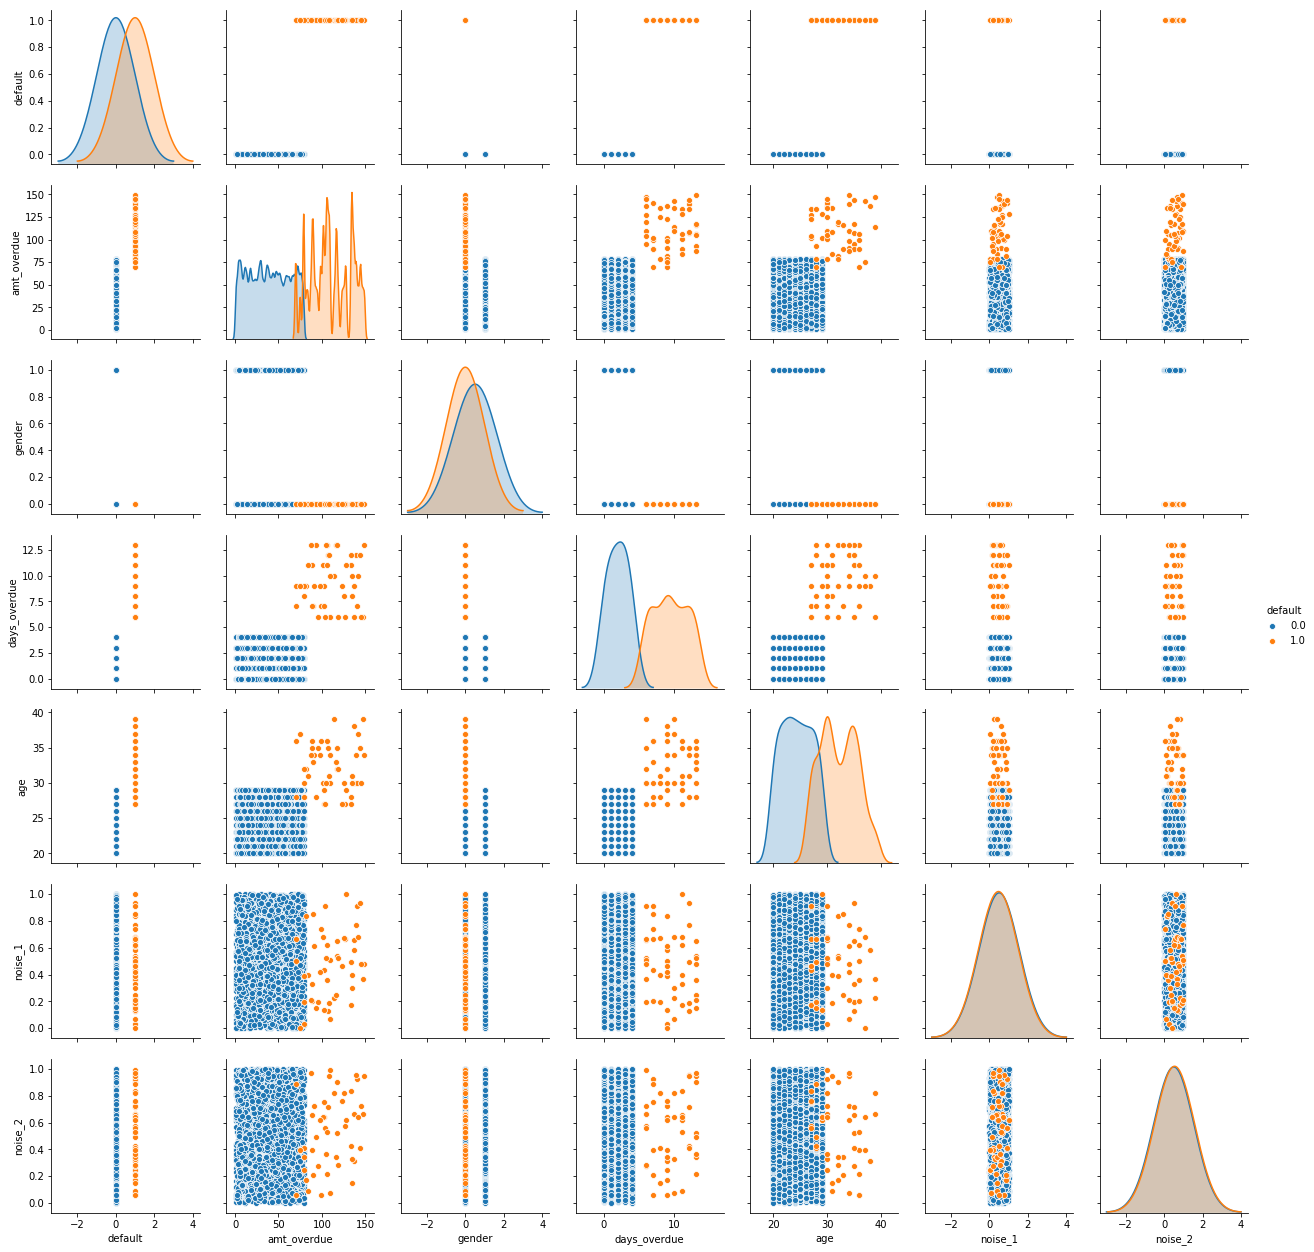

In [4]:
sns.pairplot(cards,hue='default', diag_kws={'bw': 1})

### Define X and Y and then split (stratified)

In [5]:
# Define X
X= cards.iloc[:,1:]

#Define y
y= cards.iloc[:,0]

#Split in stratified manner to reflect underlying class distribution in y . Will not need y_train.
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify= y, test_size=0.2) 

### Check baseline 

In [6]:
#check baseline 
y_test.value_counts(normalize=True)

0.0    0.983333
1.0    0.016667
Name: default, dtype: float64

## Run anomaly algorithms.  

## Define contamination : outliers_fraction= 0.0169

In [7]:
#Define contamination for  each model
outliers_fraction= 0.0169

### 1. Robust covariance .

 F1 score : 1.0
 Recall score : 1.0
 Precision score : 1.0
 roc_auc : 1.0


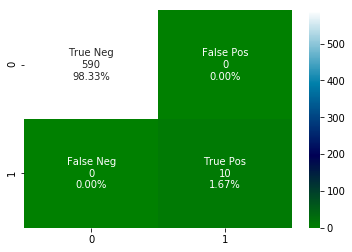

In [8]:
#Robust covariance
#sklarn comparison of robust versus one class svm . 
#https://scikit-learn.org/stable/auto_examples/applications/plot_outlier_detection_wine.html#sphx-glr-auto-examples-applications-plot-outlier-detection-wine-py

RC=EllipticEnvelope(contamination=outliers_fraction,assume_centered=False) 
get_anomaly_detection_stats(RC,X_train,X_test,y_test)

### 2. One class svm

 F1 score : 0.977772330911954
 Recall score : 0.9783333333333334
 Precision score : 0.9772419627749578
 roc_auc : 0.6449152542372882


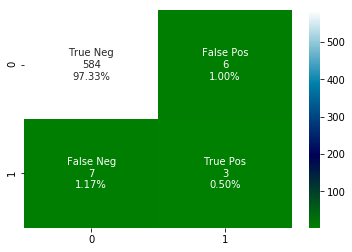

In [9]:
#One class Support Vector Machine
OSVM = svm.OneClassSVM(nu=outliers_fraction, kernel="rbf") 
get_anomaly_detection_stats(OSVM,X_train,X_test,y_test)

### 3. Isolation Forests.

 F1 score : 0.9983723090593319
 Recall score : 0.9983333333333333
 Precision score : 0.9984848484848485
 roc_auc : 0.9991525423728814


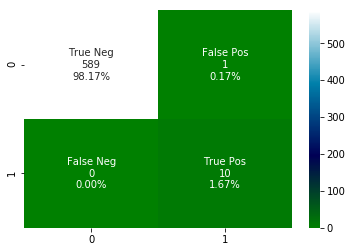

In [10]:
#Isolation Forest
IF = IsolationForest(contamination=outliers_fraction,random_state=42,n_estimators=100) 
get_anomaly_detection_stats(IF,X_train,X_test,y_test)

### 4. Local Outlier Factor



 F1 score : 0.9983723090593319
 Recall score : 0.9983333333333333
 Precision score : 0.9984848484848485
 roc_auc : 0.9991525423728814


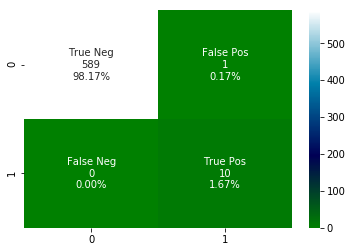

In [11]:
#Local Outlier Factor,  Set n_neighbours and contamination.
#n_neighbors: locality is given by k-nearest neighbors, whose distance is used to estimate the local density. 
## SK learn illustration : outlier detection with LOF
#https://scikit-learn.org/stable/auto_examples/neighbors/plot_lof_outlier_detection.html#sphx-glr-auto-examples-neighbors-plot-lof-outlier-detection-py
LOF = LocalOutlierFactor(n_neighbors=30, contamination=outliers_fraction,novelty= True) 
get_anomaly_detection_stats(LOF,X_train,X_test,y_test)